In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [4]:
np.random.seed(42)

In [5]:
def a20_index(y_train,y_pred):
  total = 0
  acc = 0
  for i in range(len(y_train.values)):

    temp = np.abs((y_pred[i]-y_train.values[i])/y_train.values[i])
    if temp<=0.2:
      total += 1
      acc += 1
    else:
      total += 1

  a20 = acc/total
  return a20

In [6]:
def mape(y_true, y_pred):

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Avoid division by zero by adding a small epsilon to y_true
    epsilon = 1e-10
    mape_value = np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100
    return mape_value


In [7]:
def vaf(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    numerator = np.var(y_true - y_pred)
    denominator = np.var(y_true)

    vaf_value = (1 - (numerator / denominator)) * 100
    return vaf_value


In [8]:
def rsr(y_true, y_pred):

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Compute RMSE
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))

    # Compute standard deviation of y_true
    y_mean = np.mean(y_true)
    std_dev = np.sqrt(np.mean((y_true - y_mean) ** 2))

    rsr_value = rmse / std_dev
    return rsr_value


In [9]:
def evaluation_metrics(y_true, y_pred):
  mae = mean_absolute_error(y_true, y_pred)
  r2 = r2_score(y_true, y_pred)
  rmse = np.sqrt(mean_squared_error(y_true, y_pred))
  mape_value = mape(y_true, y_pred)
  vaf_value = vaf(y_true, y_pred)
  rsr_value = rsr(y_true, y_pred)
  a20 = a20_index(y_true, y_pred)
  return mae, r2, rmse, mape_value, vaf_value, rsr_value, a20

In [10]:
# Perform Randomized Search CV for each regressor
def randomized_search(model, param_grid, X, y, cv=5, n_iter=20):
    random_search = RandomizedSearchCV(
        estimator=model, param_distributions=param_grid,
        scoring='neg_mean_squared_error', cv=cv, n_iter=n_iter,
        verbose=1, random_state=42, n_jobs=-1
    )
    random_search.fit(X, y)
    return random_search.best_params_

In [11]:
def randomized_search(model, param_grid, X, y, cv=5, n_iter=20):
    try:
        random_search = RandomizedSearchCV(
            estimator=model, param_distributions=param_grid,
            scoring='neg_mean_squared_error', cv=cv, n_iter=n_iter,
            verbose=1, random_state=42, n_jobs=-1
        )
        random_search.fit(X, y)
        return random_search.best_params_
    except AttributeError as e:
        print(f"Error in RandomizedSearchCV: {e}")


In [12]:
def get_activation(layer):
    if hasattr(layer, 'activation'):
        return layer.activation.__name__
    return "linear"

def print_equations(model, input_names=None):
    if input_names is None:
        input_dim = model.input_shape[-1]   # FIXED
        input_names = [f"x{i+1}" for i in range(input_dim)]

    prev_outputs = input_names

    for layer_idx, layer in enumerate(model.layers):
        if not hasattr(layer, "get_weights"):  # skip if no weights
            continue

        weights, biases = layer.get_weights()
        activation = layer.activation.__name__ if hasattr(layer, 'activation') else "linear"
        curr_outputs = []

        print(f"\n--- Layer {layer_idx+1} ({activation}) ---")
        for j in range(weights.shape[1]):
            eq_terms = [f"({weights[i, j]:.4f}*{prev_outputs[i]})"
                        for i in range(weights.shape[0])]
            eq = " + ".join(eq_terms) + f" + ({biases[j]:.4f})"
            if activation != "linear":
                eq = f"{activation}({eq})"
            neuron_name = f"a{layer_idx+1}_{j+1}"
            print(f"{neuron_name} = {eq}")
            curr_outputs.append(neuron_name)

        prev_outputs = curr_outputs

# print_equations(ann)

In [13]:
def model_uncertainty(y_true, y_pred):
    errors = y_true - y_pred

    rmse = np.sqrt(np.mean(errors ** 2))
    sd = np.std(errors, ddof=1)
    u95 = 1.96 * np.sqrt(sd**2 + rmse**2)

    return {
        'RMSE': rmse,
        'SD': sd,
        'U95': u95
    }

# Stone Chips

## EDA

In [14]:
stone_df = pd.read_excel("/content/drive/MyDrive/Projects/28. Materials (Stone & Bricks)/NDT V2/Stones CM+NDT.xlsx")
stone_df.head()

,Cement (kg/m3),FA (kg/m3),CA (kg/m3),Slag (kg/m3),Water (kg/m3),UPV (m/s),RN,Actual
0,340.8,1046.4,1249.2,0.0,231.6,4090,21.500000,22.334836
1,340.8,1046.4,1249.2,0.0,231.6,4090,21.333333,21.718515
2,340.8,1046.4,1249.2,0.0,231.6,4049,21.166667,21.965002
3,340.8,1046.4,936.0,272.4,231.6,4132,21.500000,20.615770
4,340.8,1046.4,936.0,272.4,231.6,4049,21.500000,22.581324


In [15]:
stone_df = stone_df.dropna()
stone_df.head()

,Cement (kg/m3),FA (kg/m3),CA (kg/m3),Slag (kg/m3),Water (kg/m3),UPV (m/s),RN,Actual
0,340.8,1046.4,1249.2,0.0,231.6,4090,21.500000,22.334836
1,340.8,1046.4,1249.2,0.0,231.6,4090,21.333333,21.718515
2,340.8,1046.4,1249.2,0.0,231.6,4049,21.166667,21.965002
3,340.8,1046.4,936.0,272.4,231.6,4132,21.500000,20.615770
4,340.8,1046.4,936.0,272.4,231.6,4049,21.500000,22.581324


In [16]:
stone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Cement (kg/m3)  75 non-null     float64
 1   FA (kg/m3)      75 non-null     float64
 2   CA (kg/m3)      75 non-null     float64
 3   Slag (kg/m3)    75 non-null     float64
 4   Water (kg/m3)   75 non-null     float64
 5   UPV (m/s)       75 non-null     int64  
 6   RN              75 non-null     float64
 7   Actual          75 non-null     float64
dtypes: float64(7), int64(1)
memory usage: 4.8 KB


In [17]:
stone_df.describe()

,Cement (kg/m3),FA (kg/m3),CA (kg/m3),Slag (kg/m3),Water (kg/m3),UPV (m/s),RN,Actual
count,75.000000,75.000000,75.00000,75.000000,7.500000e+01,75.000000,75.000000,75.000000
mean,408.000000,1007.952000,624.24000,541.200000,2.316000e+02,4292.213333,25.251111,29.637026
std,50.317693,55.394407,444.54777,383.233272,1.430655e-13,207.659824,3.042168,6.144042
min,340.800000,928.800000,0.00000,0.000000,2.316000e+02,3082.000000,20.166667,19.253368
25%,370.800000,962.400000,312.00000,272.400000,2.316000e+02,4175.000000,22.750000,24.368579
50%,405.600000,1017.600000,624.00000,543.600000,2.316000e+02,4310.000000,24.833333,29.607000
75%,440.400000,1046.400000,936.00000,816.000000,2.316000e+02,4454.000000,27.583333,34.522194
max,482.400000,1136.400000,1249.20000,1074.000000,2.316000e+02,4662.000000,32.000000,44.013293


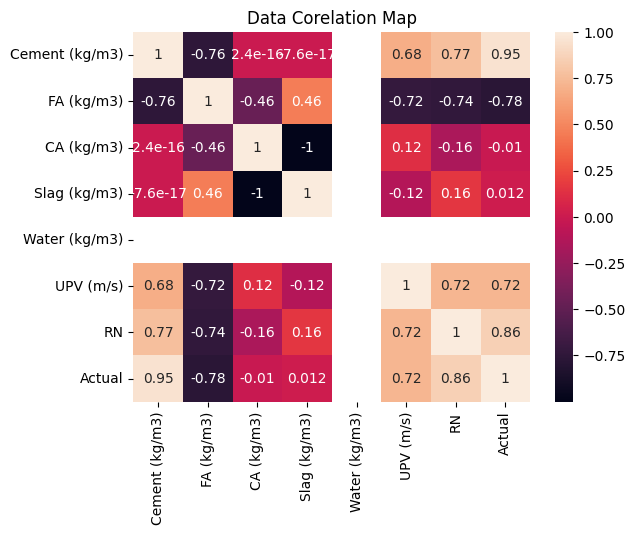

In [18]:
sns.heatmap(stone_df.corr(), annot=True)
plt.title("Data Corelation Map")
plt.show()

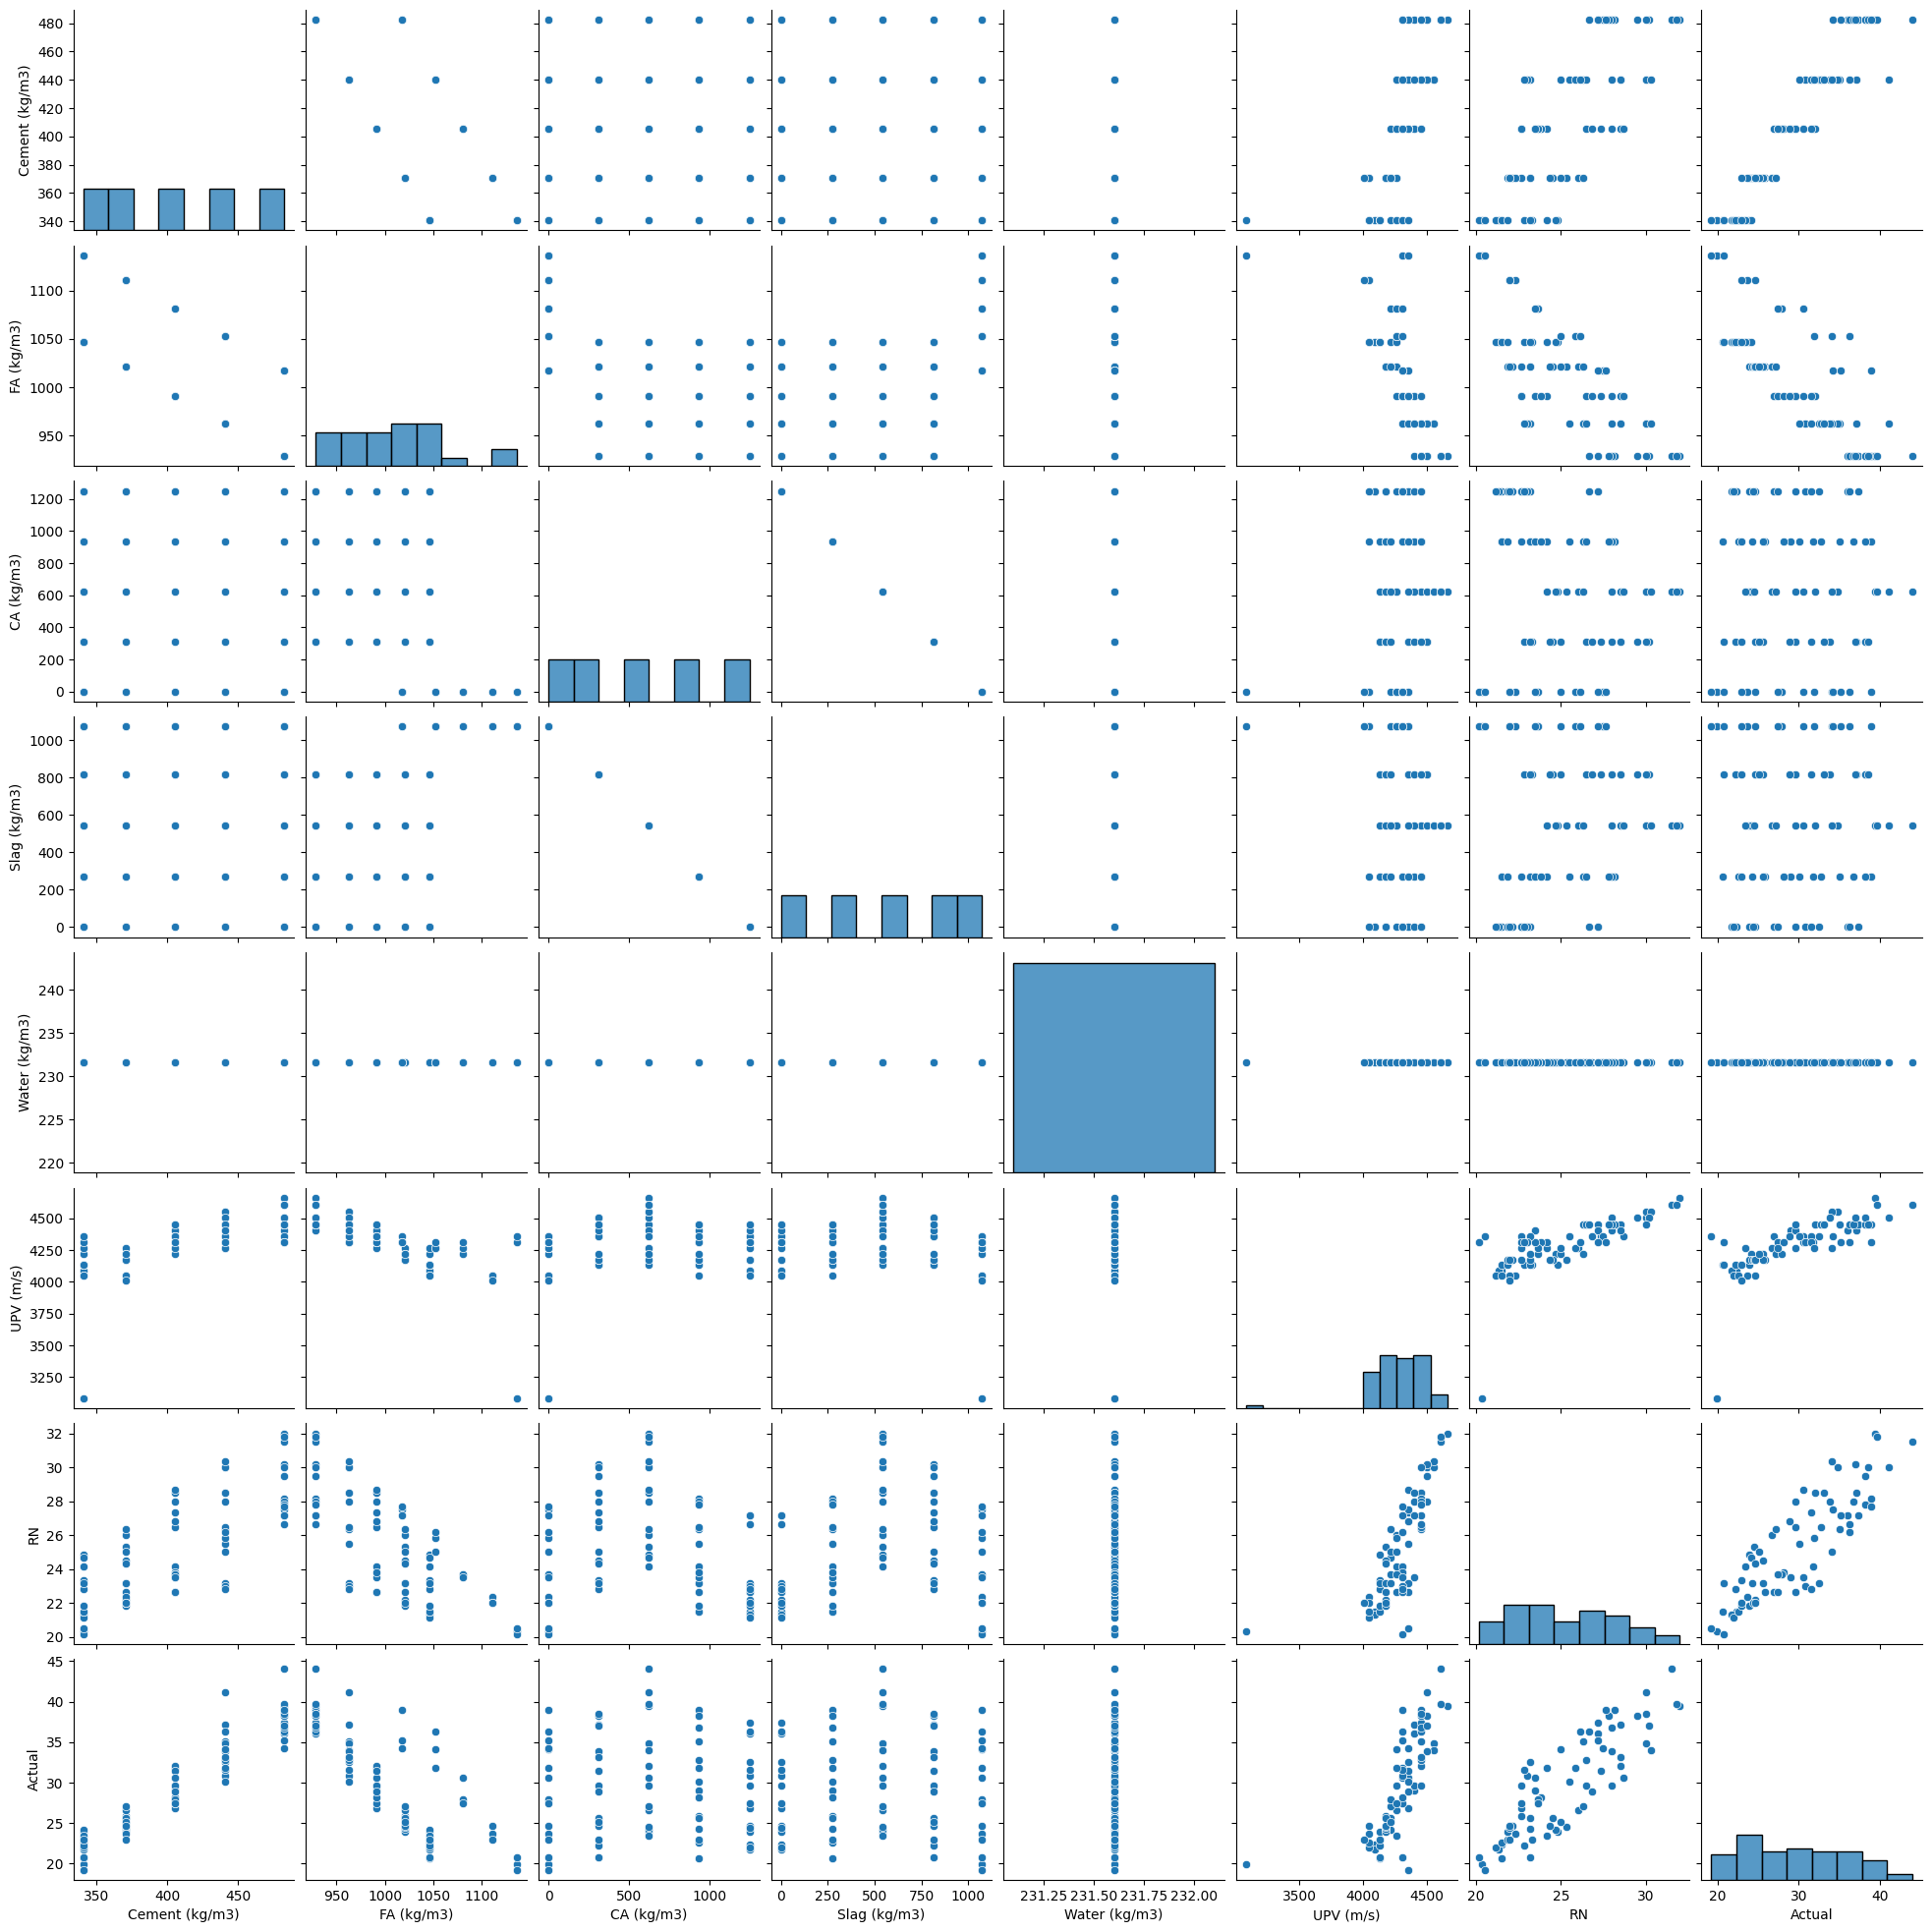

In [19]:
sns.pairplot(stone_df)
plt.show()

## Data Preprocessing

In [20]:
stone_df.columns

Index(['Cement (kg/m3)', 'FA (kg/m3)', 'CA (kg/m3)', 'Slag (kg/m3)',
       'Water (kg/m3)', 'UPV (m/s)', 'RN', 'Actual'],
      dtype='object')

In [21]:
X = stone_df.drop("Actual", axis=1)
y = stone_df["Actual"]

In [22]:
X.head()

,Cement (kg/m3),FA (kg/m3),CA (kg/m3),Slag (kg/m3),Water (kg/m3),UPV (m/s),RN
0,340.8,1046.4,1249.2,0.0,231.6,4090,21.500000
1,340.8,1046.4,1249.2,0.0,231.6,4090,21.333333
2,340.8,1046.4,1249.2,0.0,231.6,4049,21.166667
3,340.8,1046.4,936.0,272.4,231.6,4132,21.500000
4,340.8,1046.4,936.0,272.4,231.6,4049,21.500000


In [23]:
X.shape

(75, 7)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [25]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((52, 7), (23, 7), (52,), (23,))

In [26]:
# Train = X_train
# Train["Actual"] = y_train
# Test = X_test
# Test["Actual"] = y_test
# Full = X
# Full["Actual"] = y

In [27]:
Train = X_train.copy()
Train["Actual"] = y_train.copy()

Test = X_test.copy()
Test["Actual"] = y_test.copy()

Full = X.copy()
Full["Actual"] = y.copy()

In [28]:
X.shape

(75, 7)

In [29]:
X.head()

,Cement (kg/m3),FA (kg/m3),CA (kg/m3),Slag (kg/m3),Water (kg/m3),UPV (m/s),RN
0,340.8,1046.4,1249.2,0.0,231.6,4090,21.500000
1,340.8,1046.4,1249.2,0.0,231.6,4090,21.333333
2,340.8,1046.4,1249.2,0.0,231.6,4049,21.166667
3,340.8,1046.4,936.0,272.4,231.6,4132,21.500000
4,340.8,1046.4,936.0,272.4,231.6,4049,21.500000


In [30]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(X)

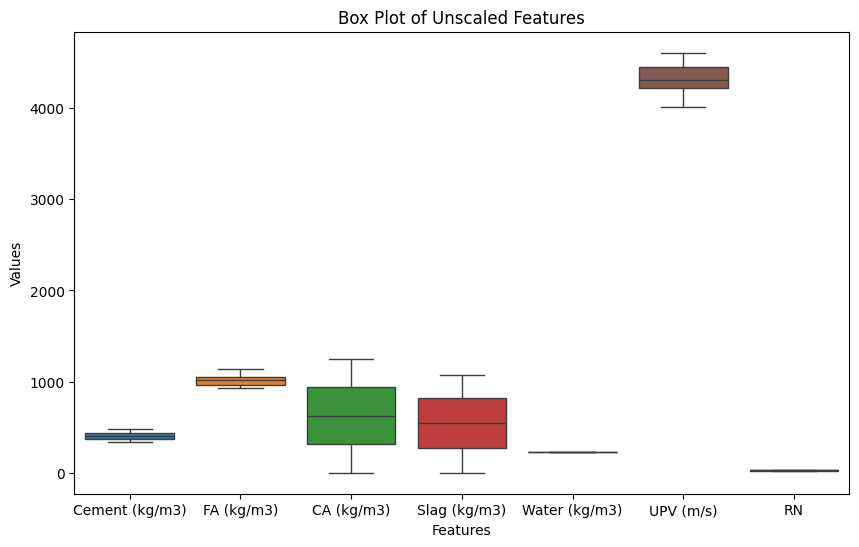

In [31]:
plt.figure(figsize=(10, 6))
sns.boxplot(X_train)
plt.title("Box Plot of Unscaled Features")
plt.xlabel("Features")
plt.ylabel("Values")
#plt.set_xticklabels(X_train.columns, rotation=45)
plt.show()

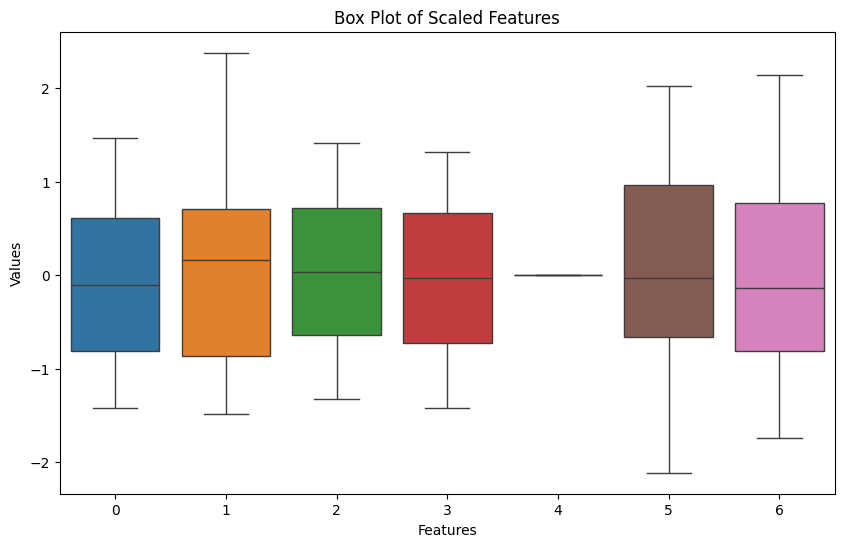

In [32]:
plt.figure(figsize=(10, 6))
sns.boxplot(X_train_scaled)
plt.title("Box Plot of Scaled Features")
plt.xlabel("Features")
plt.ylabel("Values")
plt.show()

## ANN

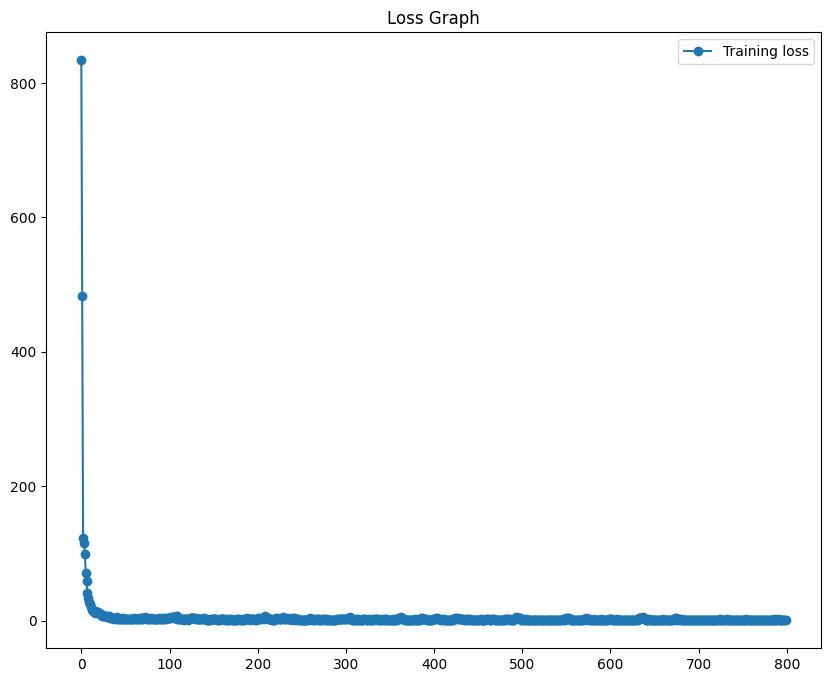

In [33]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

sann = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(X_scaled.shape[1],)),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1)
])

optimizer = Adam(learning_rate=0.0002)
sann.compile(optimizer=optimizer, loss='mse')

r = sann.fit(X_scaled, y, epochs=800, batch_size=8, verbose=0)

plt.figure(figsize=(10,8))
plt.plot(r.history['loss'], 'o-', label='Training loss')
plt.title('Loss Graph')
plt.legend()
plt.show()



In [34]:

y_pred = sann.predict(X_scaled)
mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y, y_pred.reshape(-1))
print("ANN Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
ANN Metrics:
MAE: 0.4500259387704702
R2 Score: 0.9903561001127137
RMSE: 0.599329584985696
MAPE: 1.5000498016797208
VAF: 99.1586553924706
RSR: 0.09820335985742173
A20: 1.0


In [35]:
y_pred_train = sann.predict(X_train_scaled)

mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y_train, y_pred_train.reshape(-1))
print("ANN Train Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
ANN Train Metrics:
MAE: 0.45033271008374043
R2 Score: 0.9895907690872634
RMSE: 0.6220857469715855
MAPE: 1.474273856651249
VAF: 99.21741933548837
RSR: 0.10202563850688039
A20: 1.0


In [36]:
y_pred_test = sann.predict(X_test_scaled)

print(y_pred_test.shape)

mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y_test, y_pred_test.reshape(-1))
print("ANN Test Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
(23, 1)
ANN Test Metrics:
MAE: 0.4493319542038084
R2 Score: 0.9920120764223155
RMSE: 0.5443855812232747
MAPE: 1.5583247211141817
VAF: 99.20122573839527
RSR: 0.08937518435049233
A20: 1.0


In [37]:
import shap

explainer = shap.Explainer(sann, X_scaled)

shap_values = explainer(X_scaled)
columns = ['Cement (kg/m3)', 'FA (kg/m3)', 'CA (kg/m3)', 'Slag (kg/m3)',
       'Water (kg/m3)', 'UPV (m/s)', 'RN']

shap_values.feature_names = columns


ExactExplainer explainer: 76it [00:57,  1.15it/s]


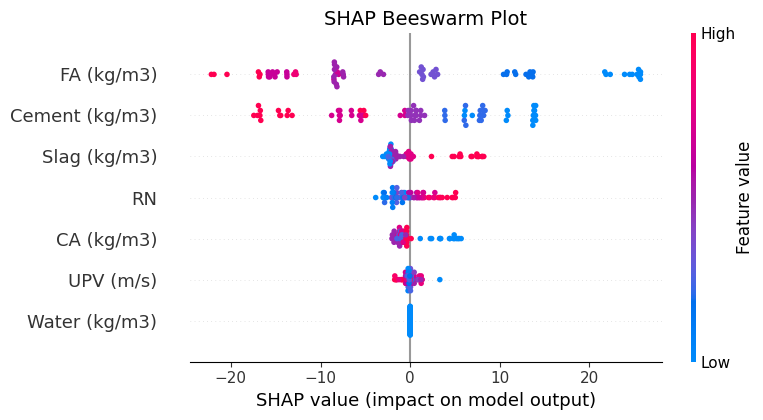

In [38]:
plt.figure(figsize=(10, 8))
shap.plots.beeswarm(shap_values, show=False)
plt.title("SHAP Beeswarm Plot", fontsize=14)
plt.tight_layout()
plt.savefig("stones_shap_beeswarm.png", dpi=600)
plt.show()


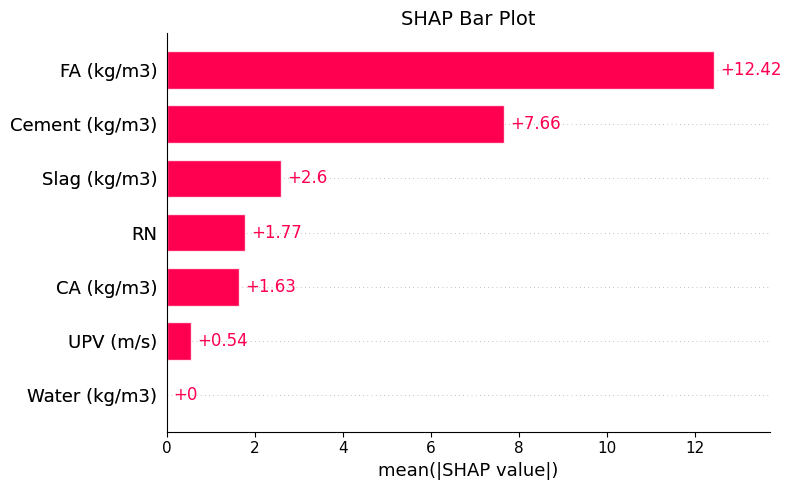

In [39]:
plt.figure(figsize=(10, 8))
shap.plots.bar(shap_values, show=False)
plt.title("SHAP Bar Plot", fontsize=14)
plt.tight_layout()
plt.savefig("stones_shap_bar.png", dpi=600)
plt.show()

In [40]:
s_uncertainity = {}
s_uncertainity['Label'] = ["Full","Train","Test"]
s_uncertainity['ANN'] = []

results = model_uncertainty(y, y_pred.reshape(-1))
print("Full Metrics")
print("RMSE:", results['RMSE'])
print("SD:", results['SD'])
print("U95:", results['U95'])
s_uncertainity['ANN'].append(results['U95'])
results = model_uncertainty(y_train, y_pred_train.reshape(-1))
print("Test Metrics")
print("RMSE:", results['RMSE'])
print("SD:", results['SD'])
print("U95:", results['U95'])
s_uncertainity['ANN'].append(results['U95'])
results = model_uncertainty(y_test, y_pred_test.reshape(-1))
print("Test Metrics")
print("RMSE:", results['RMSE'])
print("SD:", results['SD'])
print("U95:", results['U95'])
s_uncertainity['ANN'].append(results['U95'])
s_uncertainity
pd.DataFrame(s_uncertainity)

Full Metrics
RMSE: 0.599329584985696
SD: 0.5635612184546457
U95: 1.612446624641147
Test Metrics
RMSE: 0.6220857469715855
SD: 0.544655721448815
U95: 1.6205781270213866
Test Metrics
RMSE: 0.5443855812232747
SD: 0.5566141877261364
U95: 1.5260019455124751


,Label,ANN
0,Full,1.612447
1,Train,1.620578
2,Test,1.526002


In [41]:
# print_equations(ann)

In [42]:
Train["ANN Predicted"] = y_pred_train
Test["ANN Predicted"] = y_pred_test
Full["ANN Predicted"] = y_pred

## CNN

In [43]:
X_scaled.shape

(75, 7)

In [44]:
n_sample,n_features = X_scaled.shape
print(n_sample,n_features)
X_scaled_reshaped = X_scaled.reshape((n_sample,n_features,1))

75 7


In [45]:
n_sample,n_features = X_train_scaled.shape
print(n_sample,n_features)
X_train_scaled_reshaped = X_train_scaled.reshape((n_sample,n_features,1))

52 7


In [46]:
n_sample,n_features = X_test_scaled.shape
print(n_sample,n_features)
X_test_scaled_reshaped = X_test_scaled.reshape((n_sample,n_features,1))

23 7


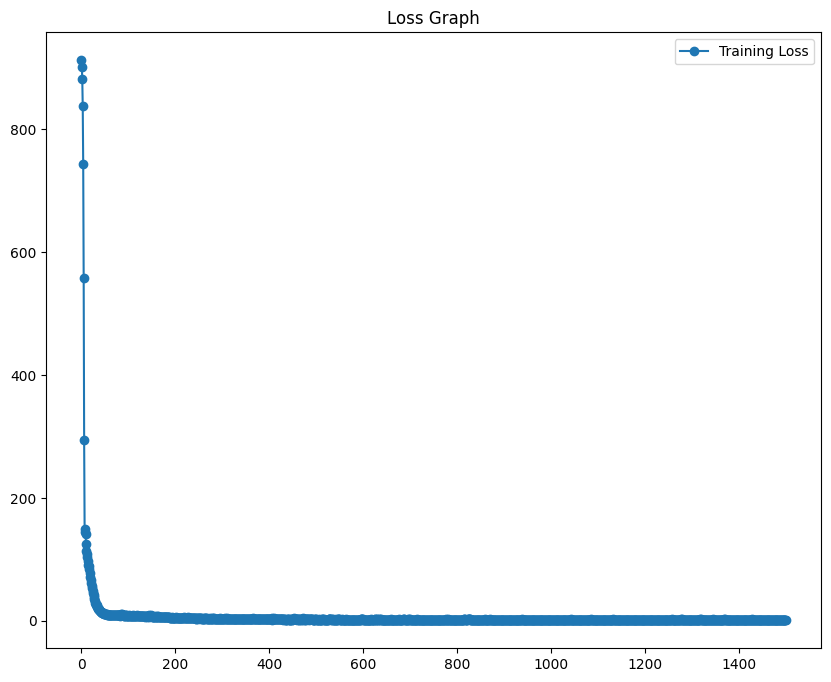

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
CNN Metrics:
MAE: 0.9934602419199533
R2 Score: 0.9543006680394821
RMSE: 1.3046508321193284
MAPE: 3.24539040258022
VAF: 97.06788993423064
RSR: 0.21377402078016378
A20: 1.0


In [47]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

scnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(64, kernel_size=1, activation='relu', input_shape=(n_features,1)),
    tf.keras.layers.Conv1D(128, kernel_size=1, activation='relu'),
    tf.keras.layers.Conv1D(256, kernel_size=1, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(256, kernel_size=1, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])

optimizer = Adam(learning_rate=0.0001)
scnn.compile(optimizer=optimizer, loss='mse')

r = scnn.fit(X_scaled, y, epochs=1500, batch_size=8, verbose=0)

plt.figure(figsize=(10,8))
plt.plot(r.history['loss'], 'o-', label='Training Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

y_pred = scnn.predict(X_scaled)
mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y, y_pred.reshape(-1))
print("CNN Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)


In [48]:
y_pred_train = scnn.predict(X_train_scaled)

mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y_train, y_pred_train.reshape(-1))
print("CNN Train Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
CNN Train Metrics:
MAE: 0.870927351181077
R2 Score: 0.9593521607400161
RMSE: 1.2293050392009828
MAPE: 2.742794700419129
VAF: 97.04556741059803
RSR: 0.20161309297757407
A20: 1.0


In [49]:
y_pred_test = scnn.predict(X_test_scaled)

mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y_test, y_pred_test.reshape(-1))
print("CNN Test Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
CNN Test Metrics:
MAE: 1.2704913741141912
R2 Score: 0.9424867421257823
RMSE: 1.4607424415940262
MAPE: 4.381694669370464
VAF: 97.47617436343265
RSR: 0.23981921915104654
A20: 1.0


In [50]:
s_uncertainity = {}
s_uncertainity['Label'] = ["Full","Train","Test"]
s_uncertainity['ANN'] = []

results = model_uncertainty(y, y_pred.reshape(-1))
print("Full Metrics")
print("RMSE:", results['RMSE'])
print("SD:", results['SD'])
print("U95:", results['U95'])
s_uncertainity['ANN'].append(results['U95'])
results = model_uncertainty(y_train, y_pred_train.reshape(-1))
print("Test Metrics")
print("RMSE:", results['RMSE'])
print("SD:", results['SD'])
print("U95:", results['U95'])
s_uncertainity['ANN'].append(results['U95'])
results = model_uncertainty(y_test, y_pred_test.reshape(-1))
print("Test Metrics")
print("RMSE:", results['RMSE'])
print("SD:", results['SD'])
print("U95:", results['U95'])
s_uncertainity['ANN'].append(results['U95'])
s_uncertainity
pd.DataFrame(s_uncertainity)

Full Metrics
RMSE: 1.3046508321193284
SD: 1.05206912624372
U95: 3.28495253897839
Test Metrics
RMSE: 1.2293050392009828
SD: 1.0582652999292208
U95: 3.179260365551347
Test Metrics
RMSE: 1.4607424415940262
SD: 0.9894000194479569
U95: 3.4579871117996084


,Label,ANN
0,Full,3.284953
1,Train,3.179260
2,Test,3.457987


In [51]:
Train["CNN Predicted"] = y_pred_train
Test["CNN Predicted"] = y_pred_test
Full["CNN Predicted"] = y_pred


In [52]:
s_uncertainity['CNN'] = []

results = model_uncertainty(y, y_pred.reshape(-1))
print("Full Metrics")
print("RMSE:", results['RMSE'])
print("SD:", results['SD'])
print("U95:", results['U95'])
s_uncertainity['CNN'].append(results['U95'])
results = model_uncertainty(y_train, y_pred_train.reshape(-1))
print("Test Metrics")
print("RMSE:", results['RMSE'])
print("SD:", results['SD'])
print("U95:", results['U95'])
s_uncertainity['CNN'].append(results['U95'])
results = model_uncertainty(y_test, y_pred_test.reshape(-1))
print("Test Metrics")
print("RMSE:", results['RMSE'])
print("SD:", results['SD'])
print("U95:", results['U95'])
s_uncertainity['CNN'].append(results['U95'])
s_uncertainity
pd.DataFrame(s_uncertainity)

Full Metrics
RMSE: 1.3046508321193284
SD: 1.05206912624372
U95: 3.28495253897839
Test Metrics
RMSE: 1.2293050392009828
SD: 1.0582652999292208
U95: 3.179260365551347
Test Metrics
RMSE: 1.4607424415940262
SD: 0.9894000194479569
U95: 3.4579871117996084


,Label,ANN,CNN
0,Full,3.284953,3.284953
1,Train,3.179260,3.179260
2,Test,3.457987,3.457987


## LSTM

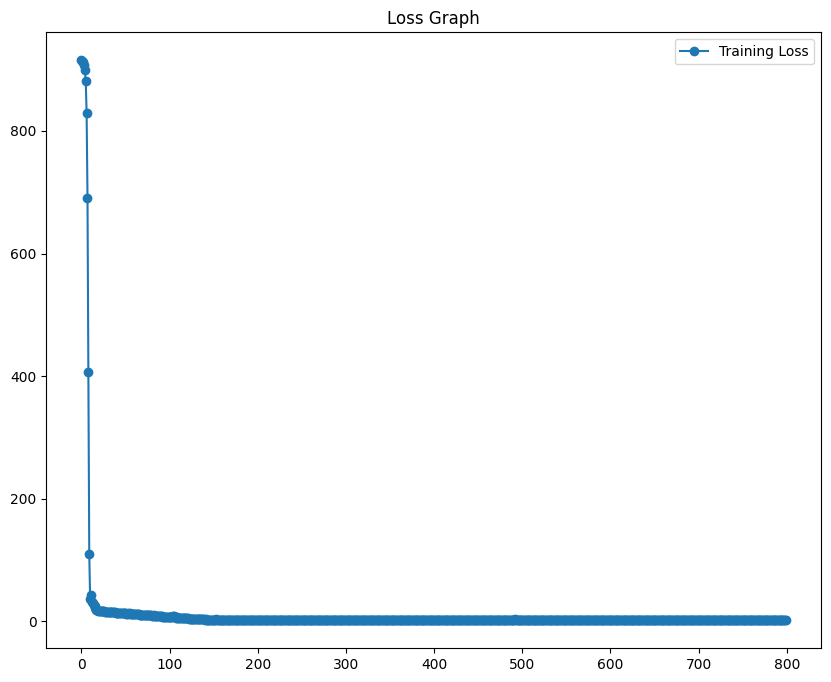

1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step
LSTM Metrics:
MAE: 1.0715216419181384
R2 Score: 0.947185109194293
RMSE: 1.4025474500804227
MAPE: 3.5000967630497724
VAF: 94.72745265407227
RSR: 0.22981490553423
A20: 1.0


In [53]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

slstm = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=True, input_shape=(n_features, 1)),
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

optimizer = Adam(learning_rate=0.0001)
slstm.compile(optimizer=optimizer, loss='mse')

r = slstm.fit(X_scaled, y, epochs=800, batch_size=8, verbose=0)

plt.figure(figsize=(10,8))
plt.plot(r.history['loss'], 'o-', label='Training Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

y_pred = slstm.predict(X_scaled)
mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y, y_pred.reshape(-1))
print("LSTM Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)


In [54]:
y_pred_train = slstm.predict(X_train_scaled)

mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y_train, y_pred_train.reshape(-1))
print("LSTM Train Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
LSTM Train Metrics:
MAE: 1.133774630308696
R2 Score: 0.9406632856990065
RMSE: 1.4852606552982532
MAPE: 3.7246636637869894
VAF: 94.11877845117844
RSR: 0.24359128535518976
A20: 1.0


In [55]:
y_pred_test = slstm.predict(X_test_scaled)

mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y_test, y_pred_test.reshape(-1))
print("LSTM Test Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
LSTM Test Metrics:
MAE: 0.9307760039066999
R2 Score: 0.9615339129840909
RMSE: 1.1946169377632283
MAPE: 2.992381285858383
VAF: 96.1972257203058
RSR: 0.19612773137909173
A20: 1.0


In [56]:
Train["LSTM Predicted"] = y_pred_train
Test["LSTM Predicted"] = y_pred_test
Full["LSTM Predicted"] = y_pred

In [57]:
s_uncertainity['LSTM'] = []

results = model_uncertainty(y, y_pred.reshape(-1))
print("Full Metrics")
print("RMSE:", results['RMSE'])
print("SD:", results['SD'])
print("U95:", results['U95'])
s_uncertainity['LSTM'].append(results['U95'])
results = model_uncertainty(y_train, y_pred_train.reshape(-1))
print("Test Metrics")
print("RMSE:", results['RMSE'])
print("SD:", results['SD'])
print("U95:", results['U95'])
s_uncertainity['LSTM'].append(results['U95'])
results = model_uncertainty(y_test, y_pred_test.reshape(-1))
print("Test Metrics")
print("RMSE:", results['RMSE'])
print("SD:", results['SD'])
print("U95:", results['U95'])
s_uncertainity['LSTM'].append(results['U95'])
s_uncertainity
pd.DataFrame(s_uncertainity)

Full Metrics
RMSE: 1.4025474500804227
SD: 1.4107965397219022
U95: 3.8991126024572
Test Metrics
RMSE: 1.4852606552982532
SD: 1.4931082094533663
U95: 4.127822977927808
Test Metrics
RMSE: 1.1946169377632283
SD: 1.2144860053174504
U95: 3.3389598883800105


,Label,ANN,CNN,LSTM
0,Full,3.284953,3.284953,3.899113
1,Train,3.179260,3.179260,4.127823
2,Test,3.457987,3.457987,3.338960


## GRU

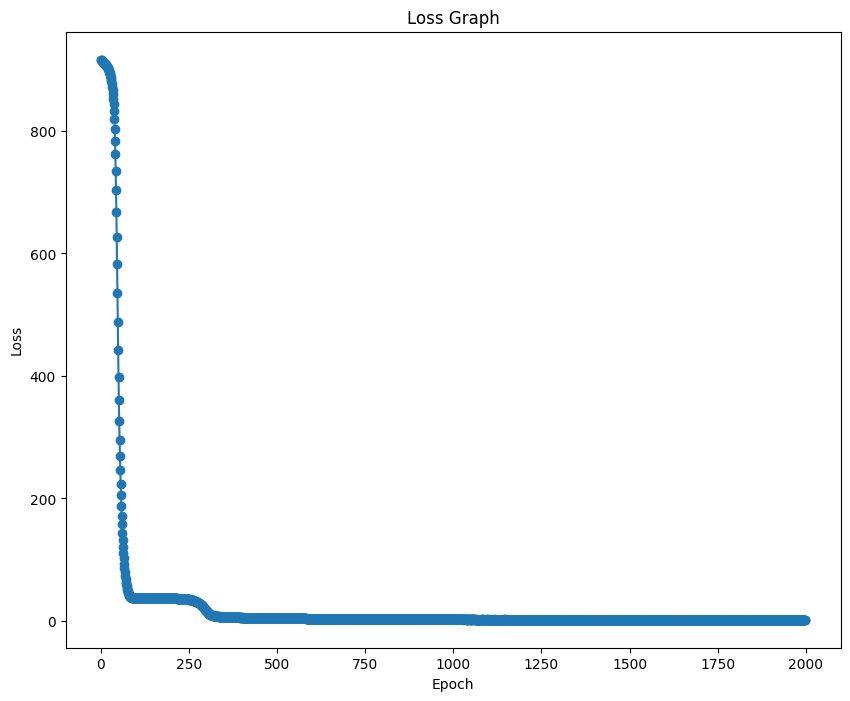

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
GRU Metrics:
MAE: 1.0508811811517822
R2 Score: 0.9498488014310206
RMSE: 1.3667215056875475
MAPE: 3.428119662069425
VAF: 94.98859020792023
RSR: 0.2239446328202116
A20: 1.0


In [58]:
import tensorflow as tf
import matplotlib.pyplot as plt

sgru = tf.keras.models.Sequential([
    tf.keras.layers.GRU(128, return_sequences=True, input_shape=(n_features, 1)),
    tf.keras.layers.GRU(64, return_sequences=False),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Use a small learning rate for precise fitting
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
sgru.compile(optimizer=optimizer, loss='mse')

# Train for many epochs to allow memorization
r = sgru.fit(X_scaled, y, epochs=2000, verbose=0)

plt.figure(figsize=(10,8))
plt.plot(r.history['loss'], 'o-')
plt.title('Loss Graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Predictions and evaluation
y_pred = sgru.predict(X_scaled)
mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y, y_pred.reshape(-1))
print("GRU Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)


In [59]:
y_pred_train = sgru.predict(X_train_scaled)

mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y_train, y_pred_train.reshape(-1))
print("GRU Train Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
GRU Train Metrics:
MAE: 1.0670162988479606
R2 Score: 0.9446519200584897
RMSE: 1.434472442285835
MAPE: 3.4486954518321853
VAF: 94.54155672711464
RSR: 0.23526172646971333
A20: 1.0


In [60]:
y_pred_test = sgru.predict(X_test_scaled)

mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y_test, y_pred_test.reshape(-1))
print("GRU Test Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
GRU Test Metrics:
MAE: 1.0144020334058967
R2 Score: 0.961217461762551
RMSE: 1.1995207854571621
MAPE: 3.3816010864888986
VAF: 96.30357389032058
RSR: 0.1969328267137022
A20: 1.0


In [61]:
Train["GRU Predicted"] = y_pred_train
Test["GRU Predicted"] = y_pred_test
Full["GRU Predicted"] = y_pred

In [62]:
s_uncertainity['GRU'] = []

results = model_uncertainty(y, y_pred.reshape(-1))
print("Full Metrics")
print("RMSE:", results['RMSE'])
print("SD:", results['SD'])
print("U95:", results['U95'])
s_uncertainity['GRU'].append(results['U95'])
results = model_uncertainty(y_train, y_pred_train.reshape(-1))
print("Test Metrics")
print("RMSE:", results['RMSE'])
print("SD:", results['SD'])
print("U95:", results['U95'])
s_uncertainity['GRU'].append(results['U95'])
results = model_uncertainty(y_test, y_pred_test.reshape(-1))
print("Test Metrics")
print("RMSE:", results['RMSE'])
print("SD:", results['SD'])
print("U95:", results['U95'])
s_uncertainity['GRU'].append(results['U95'])
s_uncertainity
pd.DataFrame(s_uncertainity)

Full Metrics
RMSE: 1.3667215056875475
SD: 1.375416089216019
U95: 3.800427916809807
Test Metrics
RMSE: 1.434472442285835
SD: 1.4384405387376171
U95: 3.9816580492369105
Test Metrics
RMSE: 1.1995207854571621
SD: 1.1973834618399262
U95: 3.3219411250424318


,Label,ANN,CNN,LSTM,GRU
0,Full,3.284953,3.284953,3.899113,3.800428
1,Train,3.179260,3.179260,4.127823,3.981658
2,Test,3.457987,3.457987,3.338960,3.321941


## Exporting Results

In [ ]:
Full.head()

,Cement (kg/m3),FA (kg/m3),CA (kg/m3),Slag (kg/m3),Water (kg/m3),UPV (m/s),RN,Actual,ANN Predicted,CNN Predicted,LSTM Predicted,GRU Predicted
0,340.8,1046.4,1249.2,0.0,231.6,4090,21.500000,22.334836,21.245802,21.990967,21.985380,22.447714
1,340.8,1046.4,1249.2,0.0,231.6,4090,21.333333,21.718515,21.092194,21.990967,21.954103,22.312967
2,340.8,1046.4,1249.2,0.0,231.6,4049,21.166667,21.965002,21.183222,21.709812,21.899506,21.954899
3,340.8,1046.4,936.0,272.4,231.6,4132,21.500000,20.615770,20.331629,21.754982,22.032055,21.934753
4,340.8,1046.4,936.0,272.4,231.6,4049,21.500000,22.581324,21.455545,22.456127,21.971188,21.542955


In [ ]:
output_dir = "/content/drive/MyDrive/Projects/28. Materials (Stone & Bricks)/NDT V2/"
Train.to_excel(f"{output_dir}V2_CM_NDT_StoneChips_Train.xlsx", index=False)
Test.to_excel(f"{output_dir}V2_CM_NDT_StoneChips_Test.xlsx", index=False)
Full.to_excel(f"{output_dir}V2_CM_NDT_StoneChips_Full.xlsx", index=False)

# Brick Chips

## EDA

In [63]:
brick_df = pd.read_excel("/content/drive/MyDrive/Projects/28. Materials (Stone & Bricks)/NDT V2/Bricks CM+NDT.xlsx")
brick_df.head()

,Cement (kg/m3),FA (kg/m3),CA (kg/m3),Slag (kg/m3),Water (kg/m3),UPV (m/s),RN,Actual
0,340.8,1083.6,895.2,0.0,231.6,3781,20.666667,21.595237
1,340.8,1083.6,895.2,0.0,231.6,3745,20.666667,20.855707
2,340.8,1083.6,895.2,0.0,231.6,3676,20.666667,20.978985
3,340.8,1083.6,670.8,310.8,231.6,3781,21.666667,22.819468
4,340.8,1083.6,670.8,310.8,231.6,3854,21.500000,20.838056


In [64]:
brick_df = brick_df.dropna()
brick_df.head()

,Cement (kg/m3),FA (kg/m3),CA (kg/m3),Slag (kg/m3),Water (kg/m3),UPV (m/s),RN,Actual
0,340.8,1083.6,895.2,0.0,231.6,3781,20.666667,21.595237
1,340.8,1083.6,895.2,0.0,231.6,3745,20.666667,20.855707
2,340.8,1083.6,895.2,0.0,231.6,3676,20.666667,20.978985
3,340.8,1083.6,670.8,310.8,231.6,3781,21.666667,22.819468
4,340.8,1083.6,670.8,310.8,231.6,3854,21.500000,20.838056


In [65]:
brick_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Cement (kg/m3)  75 non-null     float64
 1   FA (kg/m3)      75 non-null     float64
 2   CA (kg/m3)      75 non-null     float64
 3   Slag (kg/m3)    75 non-null     float64
 4   Water (kg/m3)   75 non-null     float64
 5   UPV (m/s)       75 non-null     int64  
 6   RN              75 non-null     float64
 7   Actual          75 non-null     float64
dtypes: float64(7), int64(1)
memory usage: 4.8 KB


In [66]:
brick_df.describe()

,Cement (kg/m3),FA (kg/m3),CA (kg/m3),Slag (kg/m3),Water (kg/m3),UPV (m/s),RN,Actual
count,75.000000,75.000000,75.000000,75.000000,7.500000e+01,75.000000,75.000000,75.000000
mean,408.000000,1038.288000,447.360000,587.280000,2.316000e+02,4083.813333,24.037778,29.132935
std,50.317693,46.903769,318.632477,397.019278,1.430655e-13,219.999244,2.278733,5.863900
min,340.800000,966.000000,0.000000,0.000000,2.316000e+02,3082.000000,20.166667,18.606020
25%,370.800000,1000.800000,223.200000,310.800000,2.316000e+02,3968.000000,22.333333,24.615101
50%,405.600000,1029.600000,447.600000,620.400000,2.316000e+02,4090.000000,23.666667,28.867538
75%,440.400000,1081.200000,670.800000,931.200000,2.316000e+02,4264.000000,25.833333,34.443491
max,482.400000,1136.400000,895.200000,1074.000000,2.316000e+02,4357.000000,28.333333,39.467726


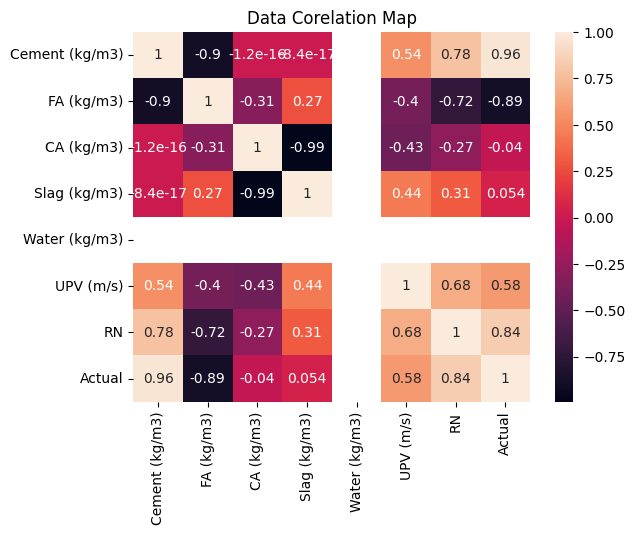

In [67]:
sns.heatmap(brick_df.corr(), annot=True)
plt.title("Data Corelation Map")
plt.show()

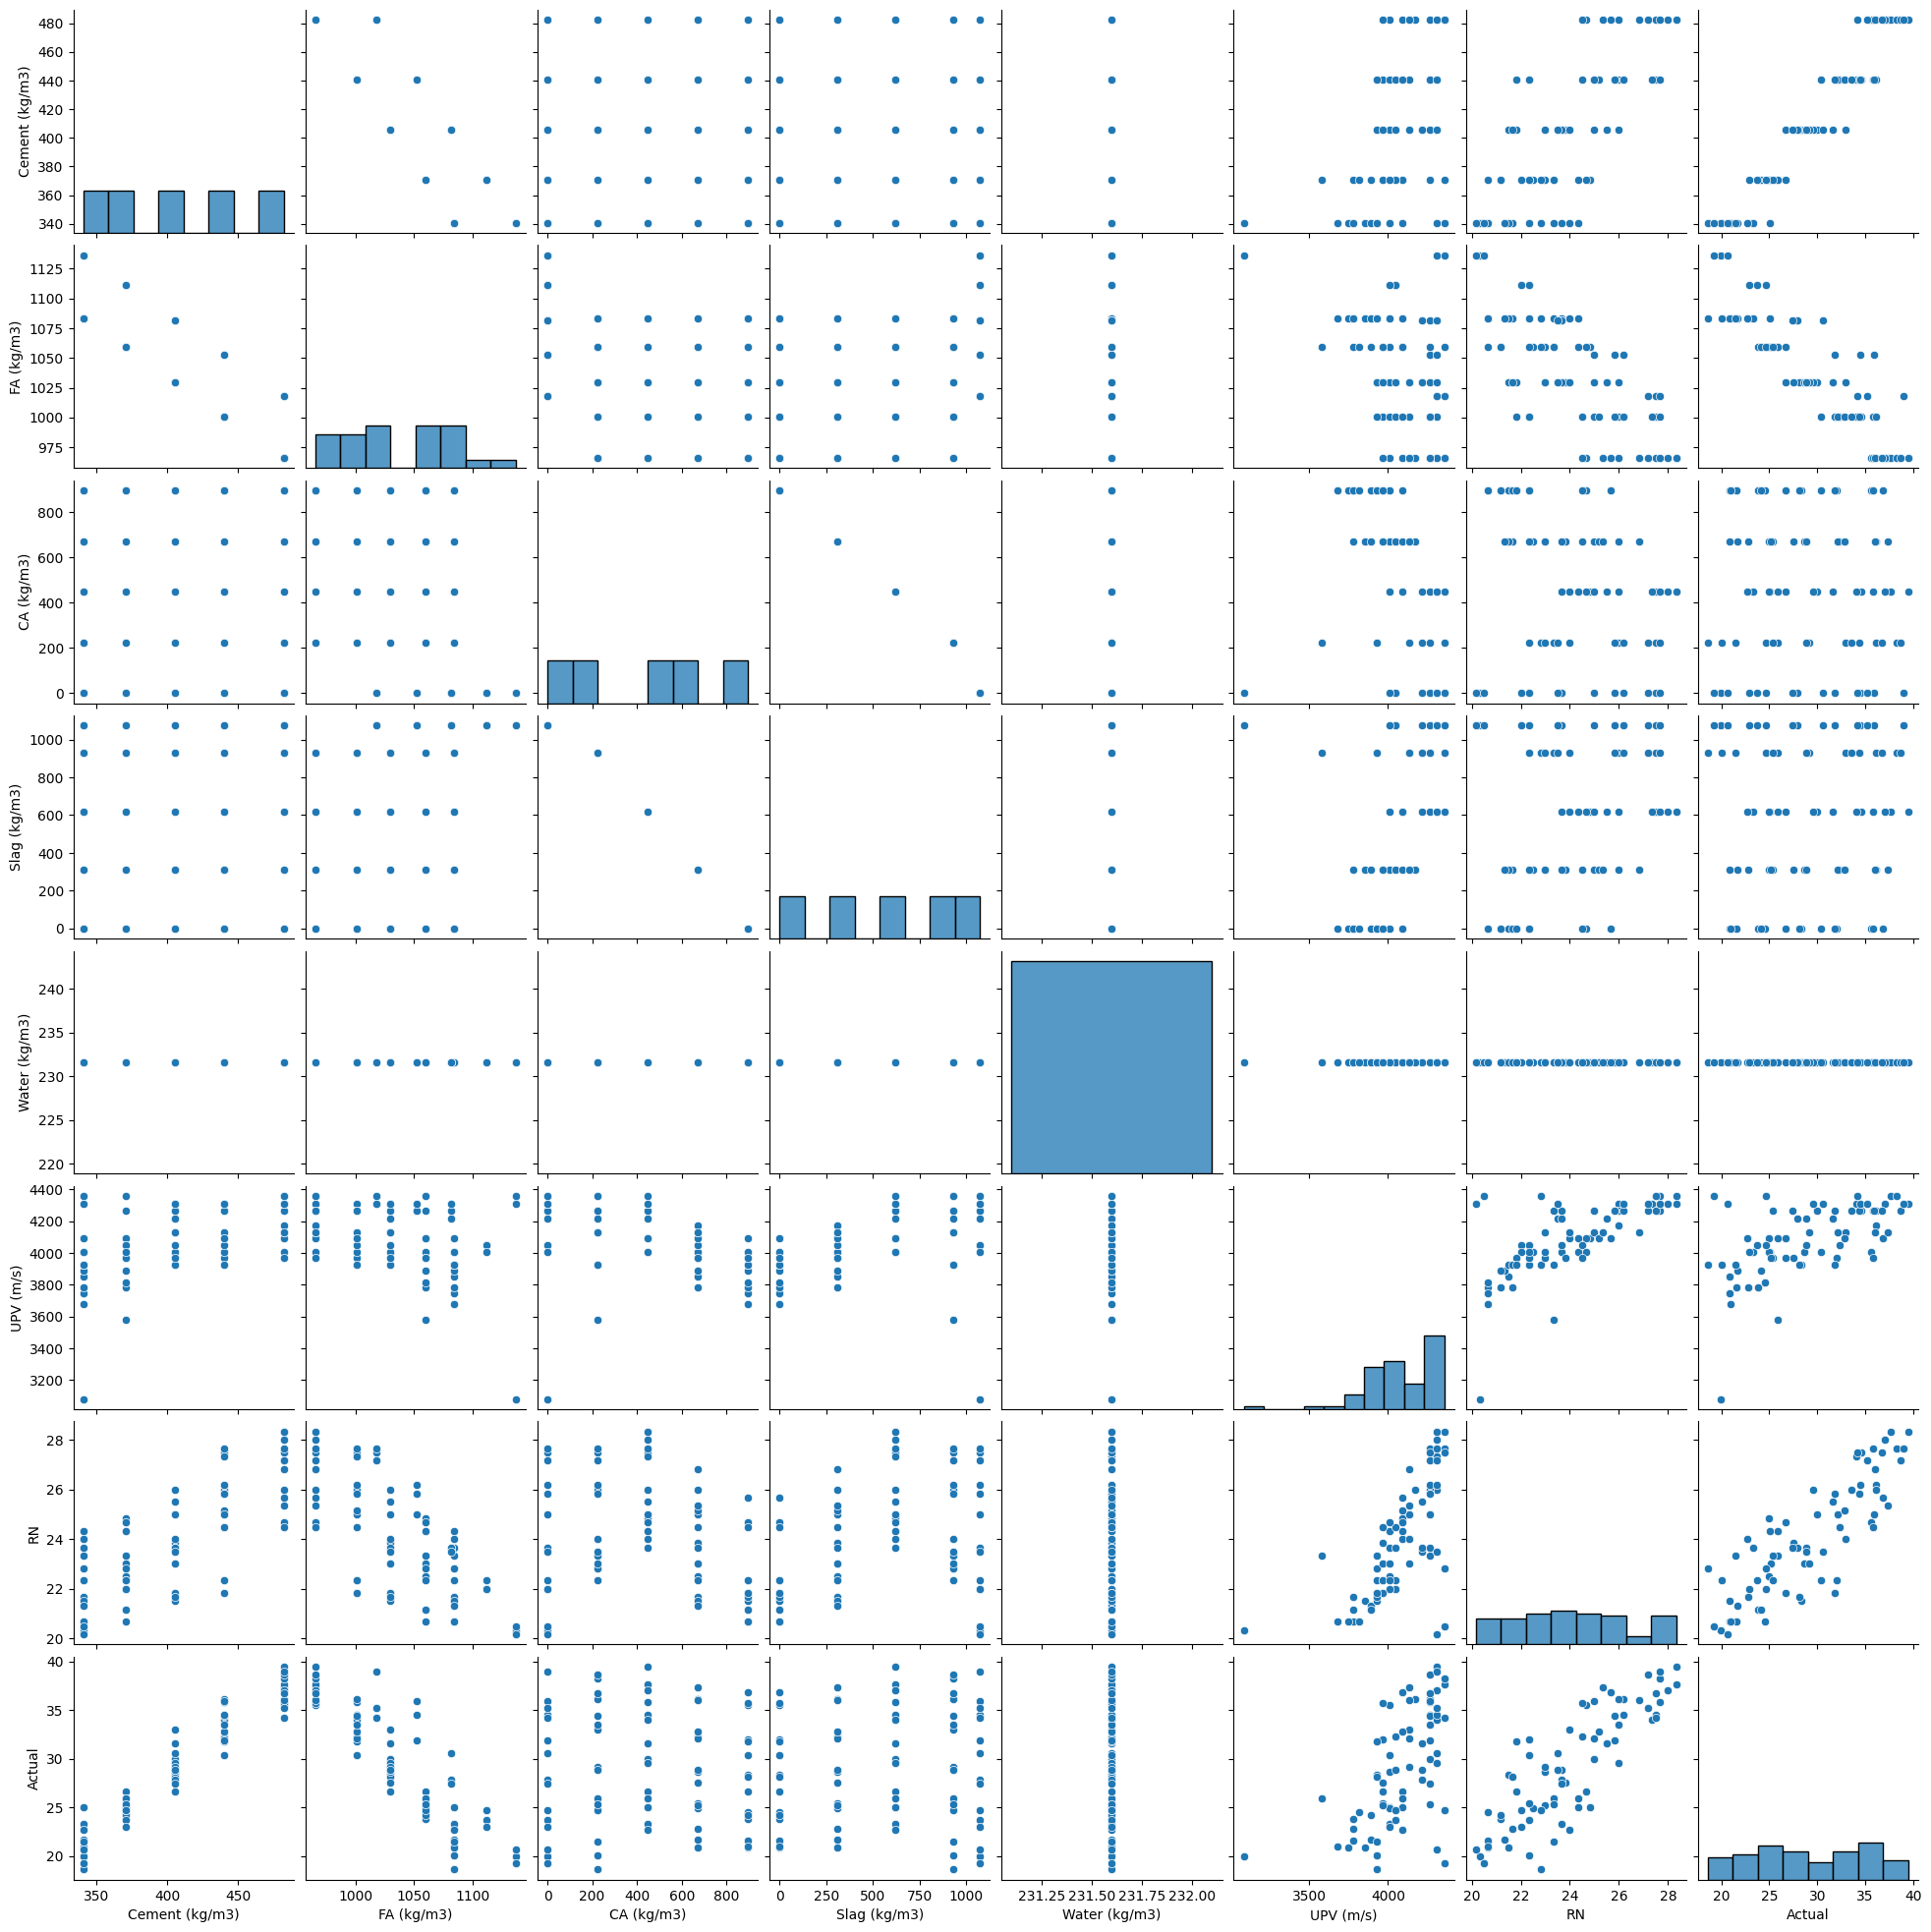

In [68]:
sns.pairplot(brick_df)
plt.show()

## Data Preprocessing

In [69]:
brick_df.columns

Index(['Cement (kg/m3)', 'FA (kg/m3)', 'CA (kg/m3)', 'Slag (kg/m3)',
       'Water (kg/m3)', 'UPV (m/s)', 'RN', 'Actual'],
      dtype='object')

In [70]:
X = brick_df.drop("Actual", axis=1)
y = brick_df["Actual"]

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [72]:
# Train = X_train
# Train["Actual"] = y_train
# Test = X_test
# Test["Actual"] = y_test
# Full = X
# Full["Actual"] = y

In [73]:
Train = X_train.copy()
Train["Actual"] = y_train.copy()

Test = X_test.copy()
Test["Actual"] = y_test.copy()

Full = X.copy()
Full["Actual"] = y.copy()

In [74]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(X)

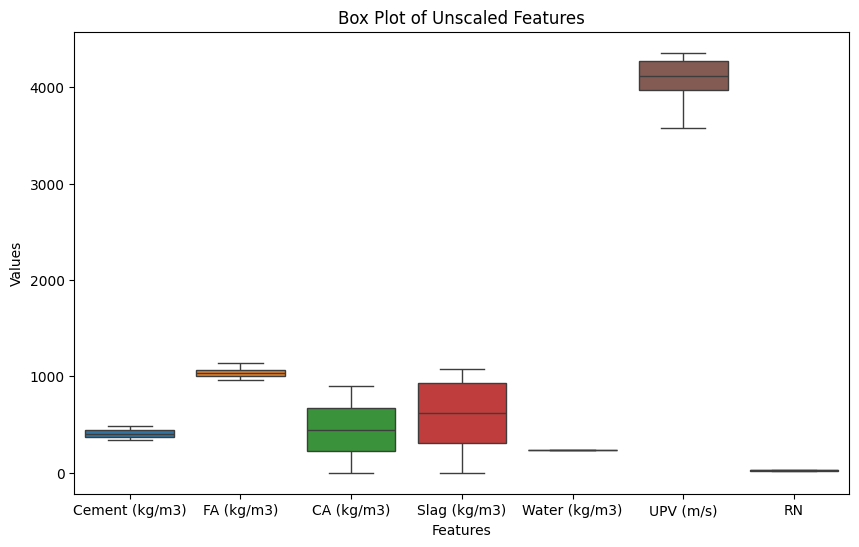

In [75]:
plt.figure(figsize=(10, 6))
sns.boxplot(X_train)
plt.title("Box Plot of Unscaled Features")
plt.xlabel("Features")
plt.ylabel("Values")
#plt.set_xticklabels(X_train.columns, rotation=45)
plt.show()

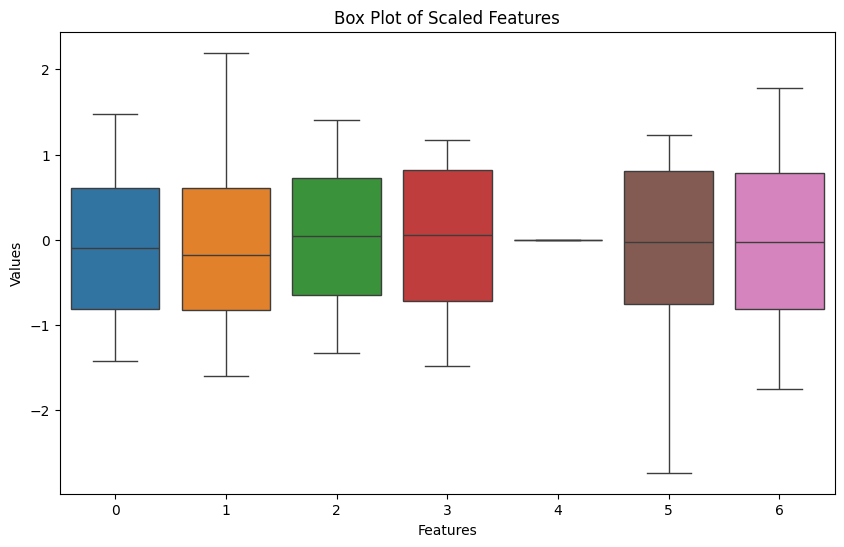

In [76]:
plt.figure(figsize=(10, 6))
sns.boxplot(X_train_scaled)
plt.title("Box Plot of Scaled Features")
plt.xlabel("Features")
plt.ylabel("Values")
plt.show()

## ANN

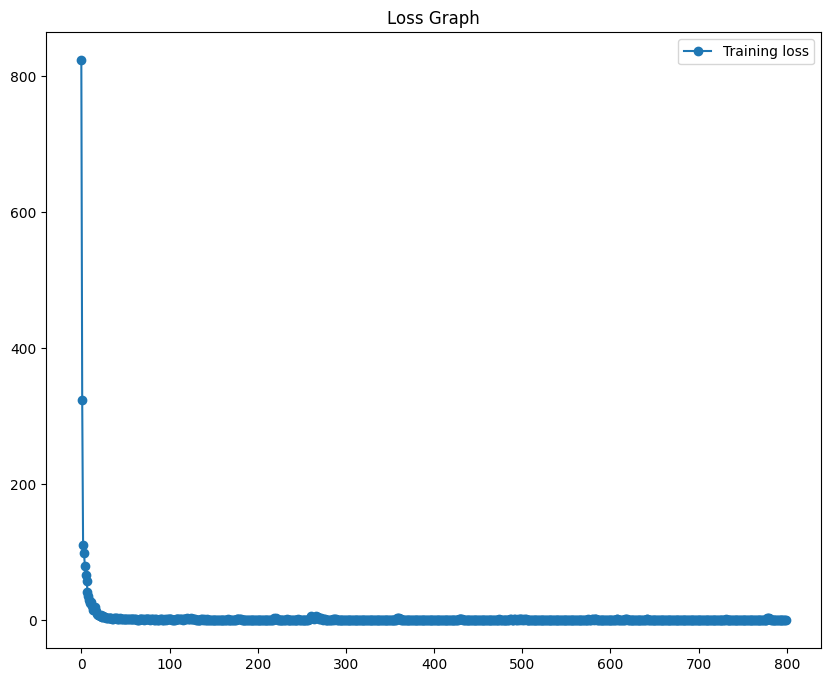

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
ANN Metrics:
MAE: 0.5442765313801127
R2 Score: 0.9867174273725335
RMSE: 0.6712941594529912
MAPE: 1.793072841910664
VAF: 99.12894264878219
RSR: 0.11525004393693936
A20: 1.0


In [77]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

ann = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(X_scaled.shape[1],)),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1)
])

optimizer = Adam(learning_rate=0.0002)
ann.compile(optimizer=optimizer, loss='mse')

r = ann.fit(X_scaled, y, epochs=800, batch_size=8, verbose=0)

plt.figure(figsize=(10,8))
plt.plot(r.history['loss'], 'o-', label='Training loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

y_pred = ann.predict(X_scaled)
mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y, y_pred.reshape(-1))
print("ANN Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)


In [78]:
y_pred_train = ann.predict(X_train_scaled)

mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y_train, y_pred_train.reshape(-1))
print("ANN Train Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
ANN Train Metrics:
MAE: 0.5544180332056682
R2 Score: 0.9860194795357118
RMSE: 0.6806983945943081
MAPE: 1.8106771922010558
VAF: 99.07190339204789
RSR: 0.11823925094607218
A20: 1.0


In [79]:
y_pred_test = ann.predict(X_test_scaled)

mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y_test, y_pred_test.reshape(-1))
print("ANN Test Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
ANN Test Metrics:
MAE: 0.5213479185571177
R2 Score: 0.987860793865241
RMSE: 0.6495307342574138
MAPE: 1.7532717815878012
VAF: 99.22823266466054
RSR: 0.11017806557913015
A20: 1.0


ExactExplainer explainer: 76it [00:53,  1.14it/s]


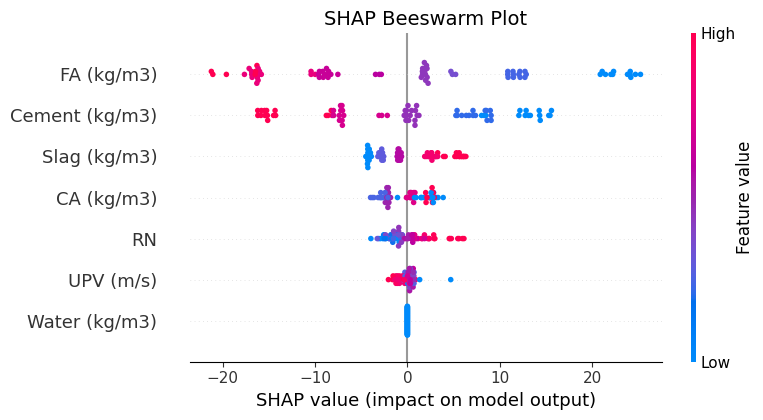

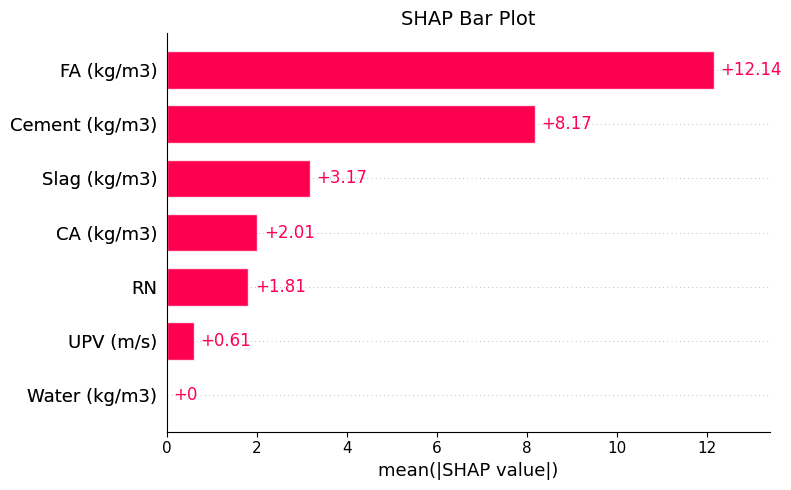

In [80]:
import shap

explainer = shap.Explainer(ann, X_scaled)

shap_values = explainer(X_scaled)
columns = ['Cement (kg/m3)', 'FA (kg/m3)', 'CA (kg/m3)', 'Slag (kg/m3)',
       'Water (kg/m3)', 'UPV (m/s)', 'RN']

shap_values.feature_names = columns
plt.figure(figsize=(10, 8))
shap.plots.beeswarm(shap_values, show=False)
plt.title("SHAP Beeswarm Plot", fontsize=14)
plt.tight_layout()
plt.savefig("bricks_shap_beeswarm.png", dpi=600)
plt.show()
plt.figure(figsize=(10, 8))
shap.plots.bar(shap_values, show=False)
plt.title("SHAP Bar Plot", fontsize=14)
plt.tight_layout()
plt.savefig("bricks_shap_bar.png", dpi=600)
plt.show()

In [82]:
Train["ANN Predicted"] = y_pred_train
Test["ANN Predicted"] = y_pred_test
Full["ANN Predicted"] = y_pred

In [83]:
b_uncertainity = {}
b_uncertainity['Label'] = ["Full","Train","Test"]
b_uncertainity['ANN'] = []

results = model_uncertainty(y, y_pred.reshape(-1))
print("Full Metrics")
print("RMSE:", results['RMSE'])
print("SD:", results['SD'])
print("U95:", results['U95'])
b_uncertainity['ANN'].append(results['U95'])
results = model_uncertainty(y_train, y_pred_train.reshape(-1))
print("Test Metrics")
print("RMSE:", results['RMSE'])
print("SD:", results['SD'])
print("U95:", results['U95'])
b_uncertainity['ANN'].append(results['U95'])
results = model_uncertainty(y_test, y_pred_test.reshape(-1))
print("Test Metrics")
print("RMSE:", results['RMSE'])
print("SD:", results['SD'])
print("U95:", results['U95'])
b_uncertainity['ANN'].append(results['U95'])
b_uncertainity
pd.DataFrame(b_uncertainity)

Full Metrics
RMSE: 0.6712941594529912
SD: 0.547280426673986
U95: 1.6975814632167567
Test Metrics
RMSE: 0.6806983945943081
SD: 0.560023476205513
U95: 1.7276670107537666
Test Metrics
RMSE: 0.6495307342574138
SD: 0.5295419091386062
U95: 1.64255111076798


,Label,ANN
0,Full,1.697581
1,Train,1.727667
2,Test,1.642551


## CNN

In [84]:
n_sample,n_features = X_scaled.shape
print(n_sample,n_features)
X_scaled_reshaped = X_scaled.reshape((n_sample,n_features,1))

75 7


In [85]:
n_sample,n_features = X_train_scaled.shape
print(n_sample,n_features)
X_train_scaled_reshaped = X_train_scaled.reshape((n_sample,n_features,1))

52 7


In [86]:
n_sample,n_features = X_test_scaled.shape
print(n_sample,n_features)
X_test_scaled_reshaped = X_test_scaled.reshape((n_sample,n_features,1))

23 7


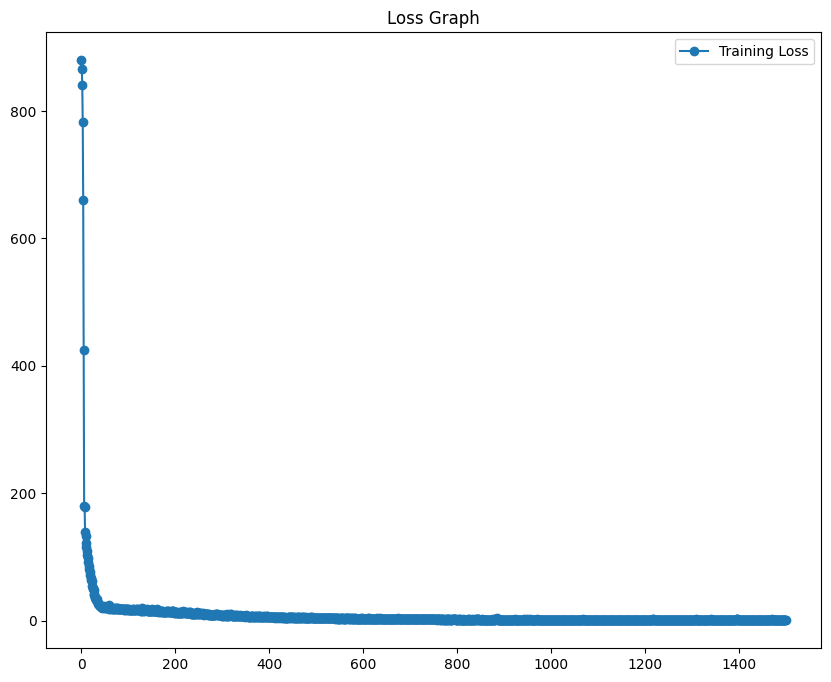

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
CNN Metrics:
MAE: 0.5886952972447171
R2 Score: 0.9802387031267424
RMSE: 0.8188031227874628
MAPE: 1.9756312925251347
VAF: 98.02568949918789
RSR: 0.14057487995106935
A20: 1.0


In [87]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(64, kernel_size=1, activation='relu', input_shape=(n_features,1)),
    tf.keras.layers.Conv1D(128, kernel_size=1, activation='relu'),
    tf.keras.layers.Conv1D(256, kernel_size=1, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(256, kernel_size=1, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])

optimizer = Adam(learning_rate=0.0001)
cnn.compile(optimizer=optimizer, loss='mse')

r = cnn.fit(X_scaled, y, epochs=1500, batch_size=8, verbose=0)

plt.figure(figsize=(10,8))
plt.plot(r.history['loss'], 'o-', label='Training Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

y_pred = cnn.predict(X_scaled)
mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y, y_pred.reshape(-1))
print("CNN Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)


In [88]:
y_pred_train = cnn.predict(X_train_scaled)

mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y_train, y_pred_train.reshape(-1))
print("CNN Train Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
CNN Train Metrics:
MAE: 0.6010329325410917
R2 Score: 0.9794183790847699
RMSE: 0.8259102271841079
MAPE: 1.9836667944651991
VAF: 97.94194144807524
RSR: 0.1434629600810958
A20: 1.0


In [89]:
y_pred_test = cnn.predict(X_test_scaled)

mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y_test, y_pred_test.reshape(-1))
print("CNN Test Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
CNN Test Metrics:
MAE: 0.560801678952795
R2 Score: 0.9814696085918231
RMSE: 0.8025033591796887
MAPE: 1.957464800584566
VAF: 98.17252343893597
RSR: 0.13612638028015342
A20: 1.0


In [90]:
Train["CNN Predicted"] = y_pred_train
Test["CNN Predicted"] = y_pred_test
Full["CNN Predicted"] = y_pred

In [105]:
b_uncertainity['CNN'] = []

results = model_uncertainty(y, y_pred.reshape(-1))
print("Full Metrics")
print("RMSE:", results['RMSE'])
print("SD:", results['SD'])
print("U95:", results['U95'])
b_uncertainity['CNN'].append(results['U95'])
results = model_uncertainty(y_train, y_pred_train.reshape(-1))
print("Test Metrics")
print("RMSE:", results['RMSE'])
print("SD:", results['SD'])
print("U95:", results['U95'])
b_uncertainity['CNN'].append(results['U95'])
results = model_uncertainty(y_test, y_pred_test.reshape(-1))
print("Test Metrics")
print("RMSE:", results['RMSE'])
print("SD:", results['SD'])
print("U95:", results['U95'])
b_uncertainity['CNN'].append(results['U95'])
b_uncertainity
pd.DataFrame(b_uncertainity)

Full Metrics
RMSE: 1.0539029199081098
SD: 1.0584778010002944
U95: 2.927617181024274
Test Metrics
RMSE: 1.084194967628808
SD: 1.0911646356925964
U95: 3.0149100669924365
Test Metrics
RMSE: 0.9819778569440069
SD: 1.0032964121047665
U95: 2.751608393408222


,Label,ANN,CNN,LSTM,GRU
0,Full,1.697581,2.927617,3.163870,2.927617
1,Train,1.727667,3.014910,3.347018,3.014910
2,Test,1.642551,2.751608,2.733086,2.751608


## LSTM

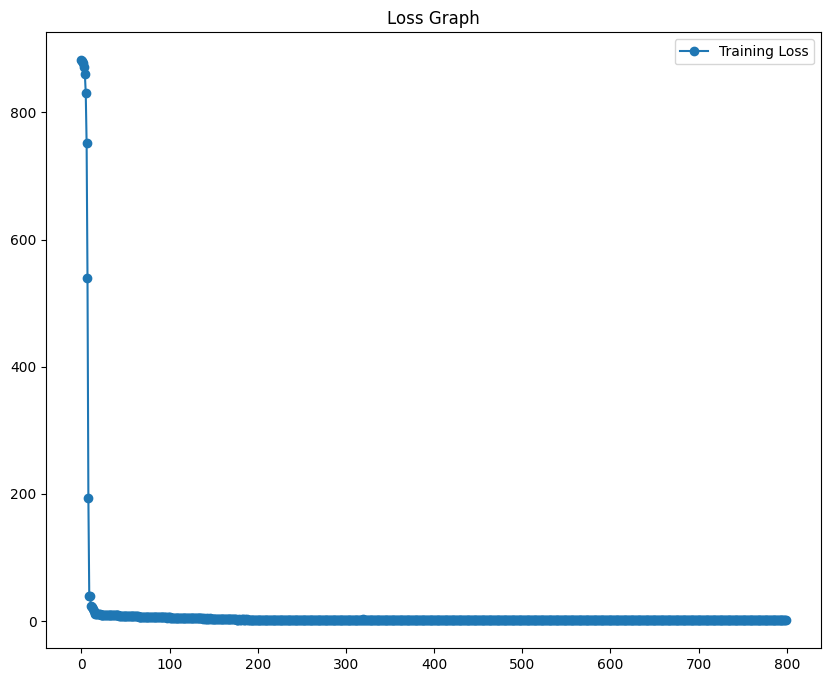

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 460ms/step
LSTM Metrics:
MAE: 0.8935242035325636
R2 Score: 0.9618425282395422
RMSE: 1.137788565149576
MAPE: 3.1471254490501184
VAF: 96.18691593207538
RSR: 0.1953393758576541
A20: 1.0


In [92]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

lstm = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=True, input_shape=(n_features, 1)),
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

optimizer = Adam(learning_rate=0.0001)
lstm.compile(optimizer=optimizer, loss='mse')

r = lstm.fit(X_scaled, y, epochs=800, batch_size=8, verbose=0)

plt.figure(figsize=(10,8))
plt.plot(r.history['loss'], 'o-', label='Training Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

y_pred = lstm.predict(X_scaled)
mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y, y_pred.reshape(-1))
print("LSTM Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)


In [93]:
y_pred_train = lstm.predict(X_train_scaled)

mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y_train, y_pred_train.reshape(-1))
print("LSTM Train Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
LSTM Train Metrics:
MAE: 0.9756205157497951
R2 Score: 0.9564331856947431
RMSE: 1.2016305434934351
MAPE: 3.419611579117812
VAF: 95.64341569754659
RSR: 0.20872664972460245
A20: 1.0


In [94]:
y_pred_test = lstm.predict(X_test_scaled)

mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y_test, y_pred_test.reshape(-1))
print("LSTM Test Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
LSTM Test Metrics:
MAE: 0.7079149010394367
R2 Score: 0.9724669097824548
RMSE: 0.9782098722871936
MAPE: 2.5310690000366467
VAF: 97.2820432780711
RSR: 0.16593098028260203
A20: 1.0


In [95]:
Train["LSTM Predicted"] = y_pred_train
Test["LSTM Predicted"] = y_pred_test
Full["LSTM Predicted"] = y_pred

In [96]:
b_uncertainity['LSTM'] = []

results = model_uncertainty(y, y_pred.reshape(-1))
print("Full Metrics")
print("RMSE:", results['RMSE'])
print("SD:", results['SD'])
print("U95:", results['U95'])
b_uncertainity['LSTM'].append(results['U95'])
results = model_uncertainty(y_train, y_pred_train.reshape(-1))
print("Test Metrics")
print("RMSE:", results['RMSE'])
print("SD:", results['SD'])
print("U95:", results['U95'])
b_uncertainity['LSTM'].append(results['U95'])
results = model_uncertainty(y_test, y_pred_test.reshape(-1))
print("Test Metrics")
print("RMSE:", results['RMSE'])
print("SD:", results['SD'])
print("U95:", results['U95'])
b_uncertainity['LSTM'].append(results['U95'])
b_uncertainity
pd.DataFrame(b_uncertainity)

Full Metrics
RMSE: 1.137788565149576
SD: 1.1450507381161152
U95: 3.163869866461839
Test Metrics
RMSE: 1.2016305434934351
SD: 1.2133405205622312
U95: 3.347018481629003
Test Metrics
RMSE: 0.9782098722871936
SD: 0.9937528993817544
U95: 2.7330858602324866


,Label,ANN,CNN,LSTM
0,Full,1.697581,2.276733,3.163870
1,Train,1.727667,2.300472,3.347018
2,Test,1.642551,2.241617,2.733086


## GRU

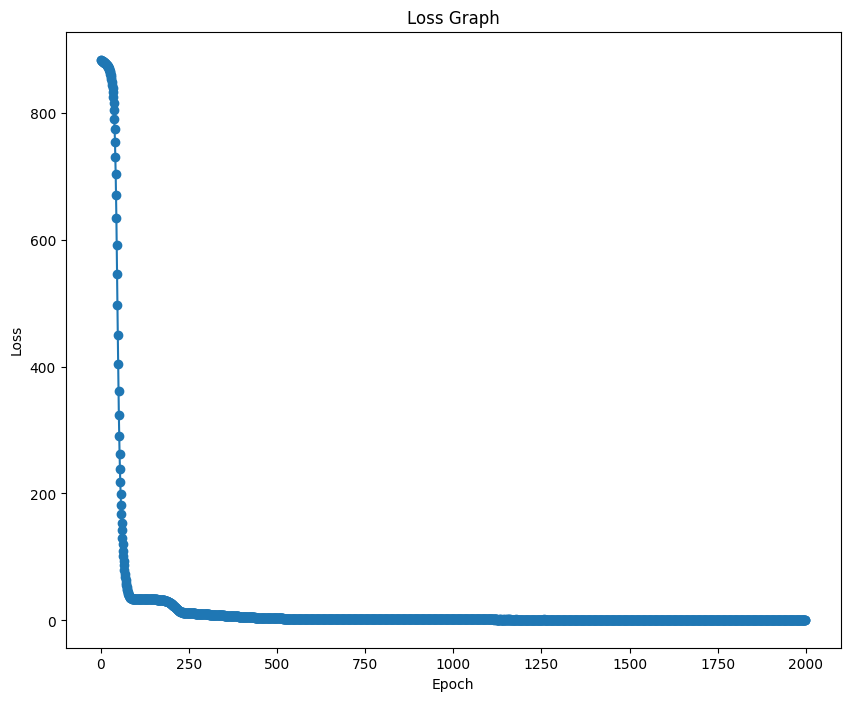

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
GRU Metrics:
MAE: 0.8146227214989294
R2 Score: 0.9672615829013074
RMSE: 1.0539029199081098
MAPE: 2.798769842423408
VAF: 96.74170481485655
RSR: 0.18093760554039795
A20: 1.0


In [97]:
import tensorflow as tf
import matplotlib.pyplot as plt

gru = tf.keras.models.Sequential([
    tf.keras.layers.GRU(128, return_sequences=True, input_shape=(n_features, 1)),
    tf.keras.layers.GRU(64, return_sequences=False),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Use a small learning rate for precise fitting
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
gru.compile(optimizer=optimizer, loss='mse')

# Train for many epochs to allow memorization
r = gru.fit(X_scaled, y, epochs=2000, verbose=0)

plt.figure(figsize=(10,8))
plt.plot(r.history['loss'], 'o-')
plt.title('Loss Graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Predictions and evaluation
y_pred = gru.predict(X_scaled)
mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y, y_pred.reshape(-1))
print("GRU Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)


In [98]:
y_pred_train = gru.predict(X_train_scaled)

mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y_train, y_pred_train.reshape(-1))
print("GRU Train Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
GRU Train Metrics:
MAE: 0.895707684347964
R2 Score: 0.9645326564942045
RMSE: 1.084194967628808
MAPE: 3.0880463211451374
VAF: 96.476605405496
RSR: 0.18832775553750833
A20: 1.0


In [99]:
y_pred_test = gru.predict(X_test_scaled)

mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y_test, y_pred_test.reshape(-1))
print("GRU Test Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
GRU Test Metrics:
MAE: 0.6313000309403618
R2 Score: 0.9722543908299136
RMSE: 0.9819778569440069
MAPE: 2.1447530557491645
VAF: 97.22958877644288
RSR: 0.1665701328872808
A20: 1.0


In [100]:
Train["GRU Predicted"] = y_pred_train
Test["GRU Predicted"] = y_pred_test
Full["GRU Predicted"] = y_pred

In [104]:
b_uncertainity['GRU'] = []

results = model_uncertainty(y, y_pred.reshape(-1))
print("Full Metrics")
print("RMSE:", results['RMSE'])
print("SD:", results['SD'])
print("U95:", results['U95'])
b_uncertainity['GRU'].append(results['U95'])
results = model_uncertainty(y_train, y_pred_train.reshape(-1))
print("Test Metrics")
print("RMSE:", results['RMSE'])
print("SD:", results['SD'])
print("U95:", results['U95'])
b_uncertainity['GRU'].append(results['U95'])
results = model_uncertainty(y_test, y_pred_test.reshape(-1))
print("Test Metrics")
print("RMSE:", results['RMSE'])
print("SD:", results['SD'])
print("U95:", results['U95'])
b_uncertainity['GRU'].append(results['U95'])
b_uncertainity
pd.DataFrame(b_uncertainity)


Full Metrics
RMSE: 1.0539029199081098
SD: 1.0584778010002944
U95: 2.927617181024274
Test Metrics
RMSE: 1.084194967628808
SD: 1.0911646356925964
U95: 3.0149100669924365
Test Metrics
RMSE: 0.9819778569440069
SD: 1.0032964121047665
U95: 2.751608393408222


,Label,ANN,CNN,LSTM,GRU
0,Full,1.697581,2.927617,3.163870,2.927617
1,Train,1.727667,3.014910,3.347018,3.014910
2,Test,1.642551,2.751608,2.733086,2.751608


## Exporting Results

In [ ]:
Full.head()

,Cement (kg/m3),FA (kg/m3),CA (kg/m3),Slag (kg/m3),Water (kg/m3),UPV (m/s),RN,Actual,ANN Predicted,CNN Predicted,LSTM Predicted,GRU Predicted
0,340.8,1083.6,895.2,0.0,231.6,3781,20.666667,21.595237,21.388805,21.952776,21.518782,21.685120
1,340.8,1083.6,895.2,0.0,231.6,3745,20.666667,20.855707,20.754551,21.320925,21.493330,21.632101
2,340.8,1083.6,895.2,0.0,231.6,3676,20.666667,20.978985,20.803247,21.289360,21.445066,21.531416
3,340.8,1083.6,670.8,310.8,231.6,3781,21.666667,22.819468,22.690426,23.255320,21.457439,21.487328
4,340.8,1083.6,670.8,310.8,231.6,3854,21.500000,20.838056,20.946995,21.865126,21.471018,21.453735


In [ ]:
output_dir = "/content/drive/MyDrive/Projects/28. Materials (Stone & Bricks)/NDT V2/"
Train.to_excel(f"{output_dir}V2_CM_NDT_BrickChips_Train.xlsx", index=False)
Test.to_excel(f"{output_dir}V2_CM_NDT_BrickChips_Test.xlsx", index=False)
Full.to_excel(f"{output_dir}V2_CM_NDT_BrickChips_Full.xlsx", index=False)

In [106]:
stones_uncertainity = pd.DataFrame(s_uncertainity)
stones_uncertainity.to_excel("stones_uncertainity.xlsx", index=False)
bricks_uncertainity = pd.DataFrame(b_uncertainity)
bricks_uncertainity.to_excel("bricks_uncertainity.xlsx", index=False)